# Ensamblar y calcular ganancia

### Autor: Federico Picado
### Fecha de última modificación: 28/10/2024
### Descripción:

Podemos evaluar la ganancia de un modelo en particular, ordenado de distinta forma.
Tambien podemos realizar ensambles entre modelos y evaluar su ganancia. 

## Parámetros

In [1]:
#ver

## Input

In [12]:
# Ya en el input se ejecutan cosas
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [3]:
base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'# Cambiar
dataset_path = base_path + 'datasets/'
dataset_file = 'Bajas_junio.csv' # df con N_cliente, clase_ternaria para junio
clientes_baja_junio= pd.read_csv(dataset_path + dataset_file)

# nombre de la carpeta donde se guardaron los resultados para cada modelo segun la metrica
dataset_folder1="predicciones_gv"
dataset_folder2="predicciones_shap"
#en el caso de tener mas modelos agregarlos


## Output

en este ultimo jobs se evalua la performance del modelo.

# MAIN

In [4]:
# Crear un diccionario para almacenar los DataFrames
dataframes = {}

# Función para cargar los CSV de una carpeta específica y asignarlos a variables
def cargar_csv_de_carpeta(dataset_folder):
    folder_path = os.path.join(dataset_path, dataset_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Nombre de la variable sin extensión
            variable_name = file_name.replace('.csv', '')
            
            # Cargar el DataFrame
            file_path = os.path.join(folder_path, file_name)
            dataframes[variable_name] = pd.read_csv(file_path)
            print(f"Archivo '{file_name}' cargado en la variable '{variable_name}'")

# Cargar los archivos de cada carpeta
cargar_csv_de_carpeta(dataset_folder1)
cargar_csv_de_carpeta(dataset_folder2)


Archivo 'predicciones_gv_bootstrap.csv' cargado en la variable 'predicciones_gv_bootstrap'
Archivo 'predicciones_gv_max.csv' cargado en la variable 'predicciones_gv_max'
Archivo 'predicciones_gv_promedio.csv' cargado en la variable 'predicciones_gv_promedio'
Archivo 'predicciones_shap_bootstrap.csv' cargado en la variable 'predicciones_shap_bootstrap'
Archivo 'predicciones_shap_max.csv' cargado en la variable 'predicciones_shap_max'
Archivo 'predicciones_shap_promedio.csv' cargado en la variable 'predicciones_shap_promedio'


In [5]:
dataframes

{'predicciones_gv_bootstrap':         numero_de_cliente  Probabilidad
 0              1462097870      0.912158
 1               606371992      0.898330
 2               560453687      0.896833
 3               627202522      0.877386
 4              1455714205      0.873753
 ...                   ...           ...
 164871          576296876      0.000009
 164872          566164387      0.000008
 164873          590935893      0.000007
 164874          652025650      0.000007
 164875          577768545      0.000006
 
 [164876 rows x 2 columns],
 'predicciones_gv_max':         numero_de_cliente  Probabilidad
 0               606371992      0.937074
 1              1462097870      0.933110
 2               627202522      0.920704
 3               560453687      0.914898
 4              1455714205      0.901547
 ...                   ...           ...
 164871          576296876      0.000016
 164872          716625469      0.000016
 164873          590935893      0.000014
 164874         

In [6]:
def calculoGanancia(bajas,prediccion,corte):
    ''' 
    Calcula la ganancia para una semilla específica.
    
    Parámetros:
    bajas: DataFrame con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: DataFrame con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    random_state: int, semilla para train_test_split.
    
    Retorna:
    ganancia_publico: Ganancia para el público.
    ganancia_privado: Ganancia para el privado.
    '''
    # Realizar el split en público y privado
    Publico, Privado = train_test_split(
        bajas,
        test_size=0.7,
        stratify=bajas['clase_ternaria'],
        random_state=32133
    )

    # Clientes que decido estimular
    estimulos = prediccion.iloc[:corte] 

    # Obtener los estímulos en el conjunto público y privado
    estimulos_publico = pd.merge(estimulos, Publico, on='numero_de_cliente', how='inner')
    estimulos_privado = pd.merge(estimulos, Privado, on='numero_de_cliente', how='inner')

    # Calcular los verdaderos positivos en cada conjunto
    TP_publico = estimulos_publico[estimulos_publico['clase_ternaria'] == 'BAJA+2']
    TP_privado = estimulos_privado[estimulos_privado['clase_ternaria'] == 'BAJA+2']

    # 5. Calcular la ganancia para cada conjunto con normalización
    # Primero, calculamos la ganancia en cada conjunto
    ganancia_publico_sin_norm = (len(TP_publico) * 273000) - ((len(estimulos_publico) - len(TP_publico)) * 7000)
    ganancia_privado_sin_norm = (len(TP_privado) * 273000) - ((len(estimulos_privado) - len(TP_privado)) * 7000)

    # Luego, normalizamos dividiendo por el porcentaje correspondiente
    ganancia_publico = ganancia_publico_sin_norm / 0.3
    ganancia_privado = ganancia_privado_sin_norm / 0.7

    return ganancia_publico, ganancia_privado

In [7]:
inicio = time.time()

resultados = []
cortes = range(11000, 12900, 200)

# Iteramos sobre cada modelo en el diccionario de predicciones
for model_name, pred_model in dataframes.items():
    # Aseguramos que las predicciones estén ordenadas por probabilidad descendente
    pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)
    
    # Iteramos sobre cada corte
    for corte in cortes:
        ganancia_publico, ganancia_privado = calculoGanancia(clientes_baja_junio, pred_model_sorted, corte)
        
        # Almacenamos los resultados
        resultados.append({
            'Modelo': model_name,
            'Corte': corte,
            'Ganancia Público': ganancia_publico,
            'Ganancia Privado': ganancia_privado
        })

# Convertimos los resultados en un DataFrame
resultados = pd.DataFrame(resultados)

fin = time.time()
tiempo_ejecucion = fin - inicio

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")


Tiempo de ejecución: 7.97 segundos


In [8]:
# Pivotamos el DataFrame 'resultados' para reorganizar las ganancias
resultados_pivot = resultados.pivot_table(
    index='Corte',
    columns='Modelo',
    values=['Ganancia Público', 'Ganancia Privado']
)

# Aplanamos las columnas para facilitar el acceso
resultados_pivot.columns = [f'{ganancia}_{modelo}' for ganancia, modelo in resultados_pivot.columns]

# Reordenamos las columnas alternando 'Público' y 'Privado' para cada modelo
# Ordenamos primero por el modelo, luego alternando entre 'Público' y 'Privado'
columnas_ordenadas = []
for modelo in resultados['Modelo'].unique():
    columnas_ordenadas.append(f'Ganancia Público_{modelo}')
    columnas_ordenadas.append(f'Ganancia Privado_{modelo}')

# Reorganizamos el DataFrame usando el nuevo orden de columnas
resultados_pivot = resultados_pivot[columnas_ordenadas]

# Convertimos el índice 'Corte' en una columna si prefieres tenerla como tal
resultados_pivot = resultados_pivot.reset_index()
resultados_pivot[["Corte","Ganancia Público_predicciones_shap_max","Ganancia Privado_predicciones_shap_max"]]

,Corte,Ganancia Público_predicciones_shap_max,Ganancia Privado_predicciones_shap_max
0,11000,9.513000e+07,93230000.0
1,11200,9.555000e+07,94250000.0
2,11400,9.681000e+07,92910000.0
3,11600,9.601667e+07,93250000.0
4,11800,9.641333e+07,93080000.0
5,12000,9.809333e+07,92360000.0
6,12200,9.781333e+07,92880000.0
7,12400,9.758000e+07,92580000.0
8,12600,9.709000e+07,92790000.0
9,12800,9.783667e+07,93670000.0


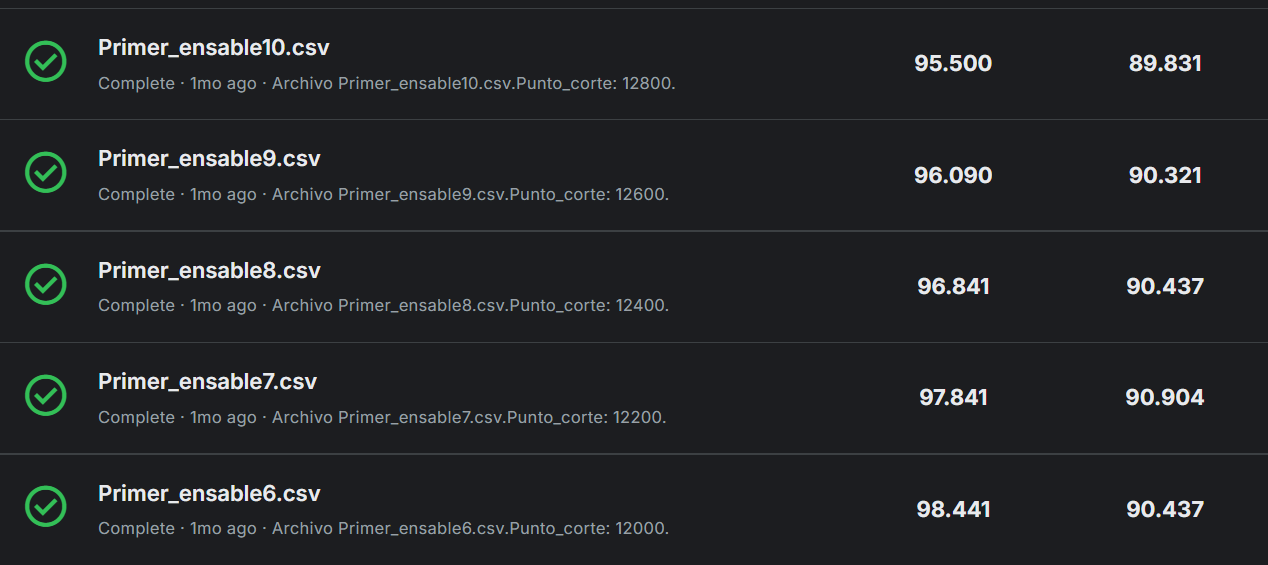
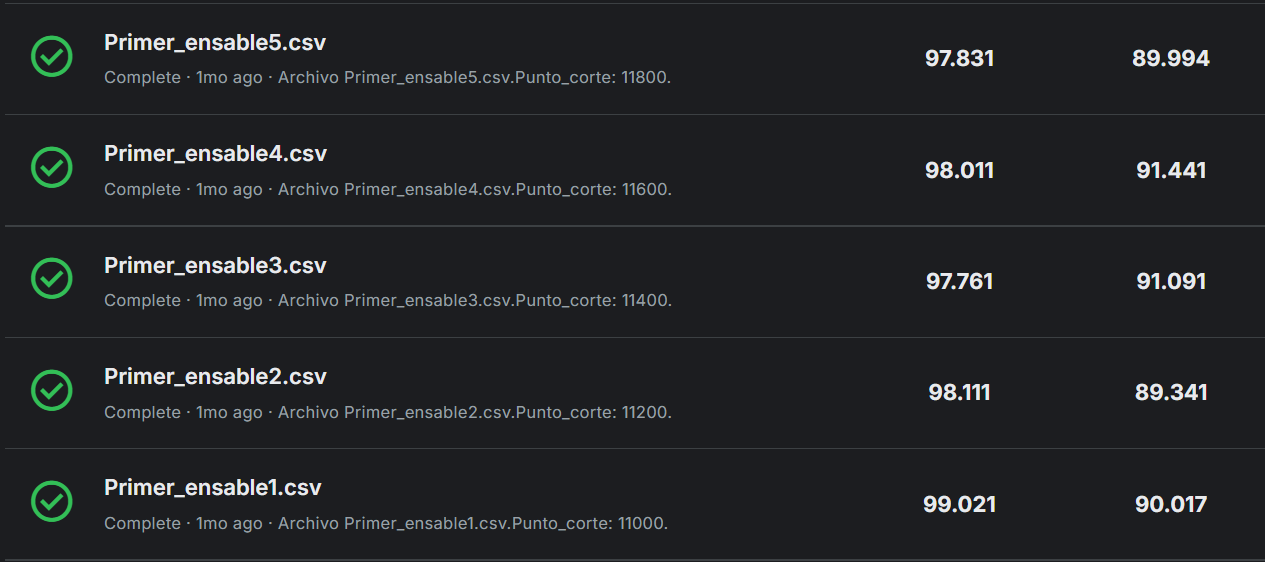

In [9]:
resultados_pivot[["Corte","Ganancia Público_predicciones_shap_promedio","Ganancia Privado_predicciones_shap_promedio"]]

,Corte,Ganancia Público_predicciones_shap_promedio,Ganancia Privado_predicciones_shap_promedio
0,11000,9.776667e+07,97300000.0
1,11200,1.000767e+08,96710000.0
2,11400,9.870000e+07,96100000.0
3,11600,9.842000e+07,95020000.0
4,11800,9.797667e+07,95210000.0
5,12000,9.762667e+07,95360000.0
6,12200,9.816333e+07,94730000.0
7,12400,9.774333e+07,94110000.0
8,12600,9.727667e+07,93910000.0
9,12800,9.797667e+07,92810000.0


In [10]:
resultados_pivot[["Corte","Ganancia Público_predicciones_shap_bootstrap","Ganancia Privado_predicciones_shap_bootstrap"]]

,Corte,Ganancia Público_predicciones_shap_bootstrap,Ganancia Privado_predicciones_shap_bootstrap
0,11000,9.776667e+07,97300000.0
1,11200,1.001000e+08,96700000.0
2,11400,9.870000e+07,96100000.0
3,11600,9.844333e+07,95010000.0
4,11800,9.795333e+07,95220000.0
5,12000,9.758000e+07,94980000.0
6,12200,9.811667e+07,94750000.0
7,12400,9.772000e+07,94120000.0
8,12600,9.730000e+07,93900000.0
9,12800,9.797667e+07,92810000.0


## Tengo el problema que segun la semilla con la que dividi el publico privado me puede dar distinto.. hago semillero

In [41]:
def calculoGanancia(bajas, prediccion, corte, random_state):
    ''' 
    Calcula la ganancia para una semilla específica.
    
    Parámetros:
    bajas: DataFrame con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: DataFrame con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    random_state: int, semilla para train_test_split.
    
    Retorna:
    ganancia_publico: Ganancia normalizada para el conjunto público.
    ganancia_privado: Ganancia normalizada para el conjunto privado.
    '''
    # Realizar el split en público y privado
    Publico, Privado = train_test_split(
        bajas,
        test_size=0.7,
        stratify=bajas['clase_ternaria'],
        random_state=random_state
    )

    # Obtener los estímulos según el modelo
    estimulos = prediccion.iloc[:corte] 

    # Obtener los estímulos en el conjunto público y privado
    estimulos_publico = pd.merge(estimulos, Publico, on='numero_de_cliente', how='inner')
    estimulos_privado = pd.merge(estimulos, Privado, on='numero_de_cliente', how='inner')

    # Calcular los verdaderos positivos en cada conjunto
    TP_publico = estimulos_publico[estimulos_publico['clase_ternaria'] == 'BAJA+2']
    TP_privado = estimulos_privado[estimulos_privado['clase_ternaria'] == 'BAJA+2']

    # Calcular la ganancia para cada conjunto con normalización
    ganancia_publico_sin_norm = (len(TP_publico) * 273000) - ((len(estimulos_publico) - len(TP_publico)) * 7000)
    ganancia_privado_sin_norm = (len(TP_privado) * 273000) - ((len(estimulos_privado) - len(TP_privado)) * 7000)

    # Normalizamos dividiendo por el porcentaje correspondiente
    ganancia_publico = ganancia_publico_sin_norm / 0.3
    ganancia_privado = ganancia_privado_sin_norm / 0.7

    return ganancia_publico, ganancia_privado

def calculoGananciaPromedio(bajas, prediccion, corte, n_seeds=100):
    '''
    Calcula la ganancia promedio para múltiples semillas.
    
    Parámetros:
    bajas: Df con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: Df con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    n_seeds: int, número de semillas aleatorias (por defecto 200).
    
    Retorna:
    promedio_ganancia_publico: Ganancia promedio normalizada para el conjunto público.
    promedio_ganancia_privado: Ganancia promedio normalizada para el conjunto privado.
    '''
    
    seeds = np.random.randint(1000, 100001, size=n_seeds)
    ganancias_publico = []
    ganancias_privado = []

    for seed in seeds:
        ganancia_publico, ganancia_privado = calculoGanancia(bajas, prediccion, corte, random_state=seed)
        ganancias_publico.append(ganancia_publico)
        ganancias_privado.append(ganancia_privado)

    promedio_ganancia_publico = np.mean(ganancias_publico)
    promedio_ganancia_privado = np.mean(ganancias_privado)

    return promedio_ganancia_publico,promedio_ganancia_privado


In [42]:
inicio = time.time()

resultados = []
cortes = range(9000, 13000, 500)

# Iteramos sobre cada modelo en el diccionario de predicciones
for model_name, pred_model in dataframes.items():
    # Aseguramos que las predicciones estén ordenadas por probabilidad descendente
    pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)
    
    # Iteramos sobre cada corte
    for corte in cortes:
        ganancia_publico, ganancia_privado = calculoGananciaPromedio(clientes_baja_junio, pred_model_sorted, corte)
        
        # Almacenamos los resultados
        resultados.append({
            'Modelo': model_name,
            'Corte': corte,
            'Ganancia Público': ganancia_publico,
            'Ganancia Privado': ganancia_privado
        })

# Convertimos los resultados en un DataFrame
resultados = pd.DataFrame(resultados)

fin = time.time()
tiempo_ejecucion = fin - inicio

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")

Tiempo de ejecución: 654.00 segundos


In [43]:
# Pivotamos el DataFrame 'resultados' para reorganizar las ganancias
resultados_pivot = resultados.pivot_table(
    index='Corte',
    columns='Modelo',
    values=['Ganancia Público', 'Ganancia Privado']
)

# Aplanamos las columnas para facilitar el acceso
resultados_pivot.columns = [f'{ganancia}_{modelo}' for ganancia, modelo in resultados_pivot.columns]

# Reordenamos las columnas alternando 'Público' y 'Privado' para cada modelo
# Ordenamos primero por el modelo, luego alternando entre 'Público' y 'Privado'
columnas_ordenadas = []
for modelo in resultados['Modelo'].unique():
    columnas_ordenadas.append(f'Ganancia Público_{modelo}')
    columnas_ordenadas.append(f'Ganancia Privado_{modelo}')

# Reorganizamos el DataFrame usando el nuevo orden de columnas
resultados_pivot = resultados_pivot[columnas_ordenadas]

# Convertimos el índice 'Corte' en una columna si prefieres tenerla como tal
resultados_pivot = resultados_pivot.reset_index()
resultados_pivot[["Corte","Ganancia Público_predicciones_shap_max","Ganancia Privado_predicciones_shap_max"]]

,Corte,Ganancia Público_predicciones_shap_max,Ganancia Privado_predicciones_shap_max
0,9000,9.546157e+07,94687900.0
1,9500,9.459683e+07,94458500.0
2,10000,9.489947e+07,94928800.0
3,10500,9.366327e+07,95258600.0
4,11000,9.494683e+07,93308500.0
5,11500,9.380770e+07,93996700.0
6,12000,9.394420e+07,94138200.0
7,12500,9.408513e+07,94277800.0


In [44]:
resultados_pivot[["Corte","Ganancia Público_predicciones_shap_promedio","Ganancia Privado_predicciones_shap_promedio"]]

,Corte,Ganancia Público_predicciones_shap_promedio,Ganancia Privado_predicciones_shap_promedio
0,9000,9.619820e+07,94772200.0
1,9500,9.802287e+07,96990200.0
2,10000,9.540720e+07,95911200.0
3,10500,9.421743e+07,96221100.0
4,11000,9.786117e+07,97259500.0
5,11500,9.644880e+07,96064800.0
6,12000,9.557240e+07,96240400.0
7,12500,9.503923e+07,94668900.0


In [45]:
resultados_pivot[["Corte","Ganancia Público_predicciones_shap_bootstrap","Ganancia Privado_predicciones_shap_bootstrap"]]

,Corte,Ganancia Público_predicciones_shap_bootstrap,Ganancia Privado_predicciones_shap_bootstrap
0,9000,9.559433e+07,95431000.0
1,9500,9.667583e+07,97567500.0
2,10000,9.443700e+07,96327000.0
3,10500,9.502803e+07,95073700.0
4,11000,9.784623e+07,97265900.0
5,11500,9.723887e+07,96126200.0
6,12000,9.585987e+07,95717200.0
7,12500,9.502383e+07,95075500.0


In [ ]:
# resultados con mayor corte
##resultados_pivot.to_csv("Resumen_predicciones.csv",index=False)

In [23]:
resp="Resumen_predicciones.csv"
respuestas_mas_rango=pd.read_csv(dataset_path + resp)

In [24]:
respuestas_mas_rango[["Corte","Ganancia Público_predicciones_shap_max","Ganancia Privado_predicciones_shap_max"]]

,Corte,Ganancia Público_predicciones_shap_max,Ganancia Privado_predicciones_shap_max
0,8000,9.145407e+07,90805400.0
1,8500,9.388237e+07,93164700.0
2,9000,9.442090e+07,95133900.0
3,9500,9.291147e+07,95180800.0
4,10000,9.503527e+07,94870600.0
5,10500,9.500890e+07,94681900.0
6,11000,9.154273e+07,94767400.0
7,11500,9.347217e+07,94140500.0
8,12000,9.483833e+07,93755000.0
9,12500,9.351930e+07,94520300.0


In [25]:
respuestas_mas_rango[["Corte","Ganancia Público_predicciones_shap_promedio","Ganancia Privado_predicciones_shap_promedio"]]

,Corte,Ganancia Público_predicciones_shap_promedio,Ganancia Privado_predicciones_shap_promedio
0,8000,9.141347e+07,92022800.0
1,8500,9.397057e+07,92326900.0
2,9000,9.509873e+07,95243400.0
3,9500,9.745213e+07,97234800.0
4,10000,9.660233e+07,95399000.0
5,10500,9.603067e+07,95444000.0
6,11000,9.759400e+07,97374000.0
7,11500,9.556447e+07,96443800.0
8,12000,9.595203e+07,96077700.0
9,12500,9.476740e+07,94785400.0


In [26]:
respuestas_mas_rango[["Corte","Ganancia Público_predicciones_shap_bootstrap","Ganancia Privado_predicciones_shap_bootstrap"]]

,Corte,Ganancia Público_predicciones_shap_bootstrap,Ganancia Privado_predicciones_shap_bootstrap
0,8000,9.075547e+07,91904800.0
1,8500,9.306290e+07,92715900.0
2,9000,9.558127e+07,95436600.0
3,9500,9.816450e+07,96929500.0
4,10000,9.564263e+07,95810300.0
5,10500,9.426270e+07,95401700.0
6,11000,9.658320e+07,97807200.0
7,11500,9.571333e+07,96780000.0
8,12000,9.569560e+07,95787600.0
9,12500,9.482830e+07,95159300.0


In [24]:
df_predicciones_shap_promedio = dataframes["predicciones_shap_promedio"]

In [22]:
df_predicciones_shap_promedio

,numero_de_cliente,Probabilidad
0,560453687,0.884568
1,1462097870,0.881342
2,606371992,0.872301
3,1021275210,0.870362
4,1455714205,0.854352
...,...,...
164871,739773904,0.000057
164872,577768545,0.000055
164873,685623441,0.000055
164874,570867526,0.000053


In [23]:
clientes_baja_junio

,numero_de_cliente,clase_ternaria
0,249584210,CONTINUA
1,249809412,CONTINUA
2,251084317,CONTINUA
3,251580228,CONTINUA
4,251873466,CONTINUA
...,...,...
164871,1573423810,CONTINUA
164872,1574789364,CONTINUA
164873,1587542270,CONTINUA
164874,1594229608,CONTINUA


In [28]:
merged_data = df_predicciones_shap_promedio.merge(clientes_baja_junio, on='numero_de_cliente', how='inner')
        
# Ordenar por probabilidad de mayor a menor
merged_data_sorted = merged_data.sort_values('Probabilidad', ascending=False)

# Seleccionar top clientes
top_clients = merged_data_sorted.iloc[:12000].copy()  # Trabajar con una copia

# Convertir 'clase_ternaria' a variable binaria para los top clientes
top_clients.loc[:, 'bajas_reales'] = (top_clients['clase_ternaria'] == 'BAJA+2').astype(int)

In [29]:
top_clients["clase_ternaria"].value_counts()

clase_ternaria
CONTINUA    10729
BAJA+2        643
BAJA+1        628
Name: count, dtype: int64

In [21]:
generar_curvas_roc_multiples(df_predicciones_shap_promedio,clientes_baja_junio,11000)

AttributeError: 'Series' object has no attribute 'merge'

<Figure size 1000x600 with 0 Axes>